People always look at a player's performance over the past season or several as an indicator of his skills. But how accurate is it actually at predicting the same player's performance in the new season? How many seasons back should be look? And how much the player's team can affect it? Those are the main topics this notebook aims to research.

At first, we are going to test out a simple model where we are only interested in the points (goals + assists) and, therefore, only the skaters. If the model shows any promising result, we can attempt expanding it to the other key performance indicators as well.

In [1]:
# Importing standard packages for data exploration and processing.
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


# We do not need the whole dataframe.
columns_read = ['Profile', 'Season', 'Year', 'Team', 'Games', 'Goals', 'Assists', 'Points', 'Plus_minus', 'Penalties', 'Shots',
                'Icetime_game_seconds']
data = pd.read_csv('../data/players/skaters_season.csv', usecols=columns_read)
data.head()

,Profile,Season,Year,Team,Games,Goals,Assists,Points,Plus_minus,Penalties,Shots,Icetime_game_seconds
0,https://en.khl.ru/players/16673/,Regular season,2014/2015,Amur (Khabarovsk),13,1,0,1,-4,6,11,417
1,https://en.khl.ru/players/16673/,Regular season,2013/2014,Amur (Khabarovsk),12,0,0,0,0,0,14,375
2,https://en.khl.ru/players/19200/,Regular season,2017/2018,Dinamo (Minsk),8,0,0,0,-1,0,6,360
3,https://en.khl.ru/players/19200/,Regular season,2016/2017,Dinamo (Minsk),20,3,1,4,1,10,21,583
4,https://en.khl.ru/players/19200/,Regular season,2015/2016,Dinamo (Minsk),11,1,0,1,1,0,5,283


We will definitely need the total time on ice over the season. After all, two players might be equally skilled but one of them simply gets much more icetime and thus gets more points. What we are going to use is not the points over the season but really a standartised amount of points over a certain interval. For ease of browse, let us set the interval as 60 minutes (standard match length) the same as with goalies.

In [2]:
data['Icetime'] = data['Games'] * data['Icetime_game_seconds'] / 3600
data['Goals_average'] = data['Goals'] / data['Icetime']
data['Assists_average'] = data['Assists'] / data['Icetime']
data['Points_average'] = data['Points'] / data['Icetime']
data['Plus_minus_average'] = data['Plus_minus'] / data['Icetime']
data['Penalties_average'] = data['Penalties'] / data['Icetime']
data['Shots_average'] = data['Shots'] / data['Icetime']
data.head()

,Profile,Season,Year,Team,Games,Goals,Assists,Points,Plus_minus,Penalties,Shots,Icetime_game_seconds,Icetime,Goals_average,Assists_average,Points_average,Plus_minus_average,Penalties_average,Shots_average
0,https://en.khl.ru/players/16673/,Regular season,2014/2015,Amur (Khabarovsk),13,1,0,1,-4,6,11,417,1.505833,0.664084,0.000000,0.664084,-2.656336,3.984505,7.304925
1,https://en.khl.ru/players/16673/,Regular season,2013/2014,Amur (Khabarovsk),12,0,0,0,0,0,14,375,1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,11.200000
2,https://en.khl.ru/players/19200/,Regular season,2017/2018,Dinamo (Minsk),8,0,0,0,-1,0,6,360,0.800000,0.000000,0.000000,0.000000,-1.250000,0.000000,7.500000
3,https://en.khl.ru/players/19200/,Regular season,2016/2017,Dinamo (Minsk),20,3,1,4,1,10,21,583,3.238889,0.926244,0.308748,1.234991,0.308748,3.087479,6.483705
4,https://en.khl.ru/players/19200/,Regular season,2015/2016,Dinamo (Minsk),11,1,0,1,1,0,5,283,0.864722,1.156441,0.000000,1.156441,1.156441,0.000000,5.782204


Since we are using averages we need to ensure that all players have participated at a certain bare mininum during the season. Otherwise, their results that season are not accurate enough to base any predictions off. They are also subject to a lot of fluctuation that would end up getting accredited to other factors.

This could be accounted for in several ways, based off either games played, points scored or icetime recorded. We are going to use all three. Let us set the minimum requirement at 30 games, 10 minutes of icetime per game and 10 points.

On a related note, let us drop all playoff seasons from the data. Not only they tend to be fairly short and would be mostly sorted out based on the icetime required, but the playoff matches tend to behave somewhat differently than the regular season.

In [3]:
data = data[data['Season'] == 'Regular season']
data = data[data['Games'] >= 30]
data = data[data['Icetime_game_seconds'] >= 600]
data = data[data['Points'] >= 10]

In [4]:
data.describe()

,Games,Goals,Assists,Points,Plus_minus,Penalties,Shots,Icetime_game_seconds,Icetime,Goals_average,Assists_average,Points_average,Plus_minus_average,Penalties_average,Shots_average
count,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000,4794.000000
mean,48.821652,8.861911,13.154777,22.016688,1.805173,31.386525,90.981018,1003.364622,13.674114,0.666947,0.959814,1.626762,0.125831,2.342477,6.722637
std,7.585640,5.492832,6.993532,10.798156,9.907838,21.526449,36.000433,173.329671,3.435627,0.383170,0.419469,0.661923,0.734564,1.637683,2.183231
min,30.000000,0.000000,0.000000,10.000000,-33.000000,0.000000,15.000000,600.000000,5.287222,0.000000,0.000000,0.447094,-2.482034,0.000000,1.206399
25%,44.000000,5.000000,8.000000,14.000000,-5.000000,16.000000,64.000000,878.000000,11.158472,0.370868,0.662282,1.123944,-0.359412,1.286591,5.108898
50%,50.000000,8.000000,12.000000,19.000000,1.000000,26.000000,85.000000,996.000000,13.555556,0.622470,0.882029,1.530128,0.105529,1.950302,6.524440
75%,54.000000,12.000000,16.000000,27.000000,8.000000,41.000000,111.000000,1119.750000,15.978472,0.902487,1.188363,2.016524,0.592085,2.960906,8.141437
max,63.000000,48.000000,65.000000,85.000000,48.000000,236.000000,253.000000,1720.000000,26.500000,2.388060,3.964489,5.162264,3.026164,24.871194,16.336693


Important note! We have some rows where Team is specified as "Summary:". That is the case when a player has changed his team during the season, so he ends up having a separate row of statistics for both teams and for them combined.

Ideally, we want to take such cases into account but it present problems of its own. If we keep just the summary, we cannot include teams in our model. If we keep the statistics for each team separately, the rows might fail the icetime requirement even if the player had enough icetime that season to get included. For now, let us go with the latter approach.

In [5]:
data = data[data['Team'] != 'Summary']

In [6]:
data.groupby('Team').mean()

,Games,Goals,Assists,Points,Plus_minus,Penalties,Shots,Icetime_game_seconds,Icetime,Goals_average,Assists_average,Points_average,Plus_minus_average,Penalties_average,Shots_average
Team,,,,,,,,,,,,,,,
Admiral (Vladivostok),49.764045,8.426966,11.764045,20.191011,-0.764045,29.561798,89.865169,996.123596,13.819042,0.639952,0.842751,1.482703,-0.074785,2.167108,6.578933
Ak Bars (Kazan),49.359375,9.479167,14.411458,23.890625,9.583333,31.828125,91.609375,990.005208,13.640472,0.719769,1.047380,1.767149,0.710034,2.394759,6.740267
Amur (Khabarovsk),49.251613,7.793548,11.329032,19.122581,-4.806452,29.658065,90.296774,1013.832258,13.924505,0.580387,0.819575,1.399963,-0.373674,2.138441,6.554286
Atlant (Moscow Region),49.220930,9.360465,13.546512,22.906977,5.686047,33.860465,90.046512,1004.720930,13.787251,0.704354,0.973697,1.678051,0.372139,2.515252,6.677239
Avangard (Omsk),49.742690,9.269006,14.385965,23.654971,6.526316,28.654971,98.385965,1026.005848,14.259246,0.675219,1.012889,1.688108,0.454124,2.102650,6.948086
Avtomobilist (Ekaterinburg),48.938776,8.870748,12.993197,21.863946,0.006803,28.666667,90.993197,1014.394558,13.882591,0.657421,0.932536,1.589958,-0.001625,2.038422,6.621369
Barys (Nur-Sultan),49.994318,10.494318,15.346591,25.840909,2.051136,34.386364,99.960227,1045.392045,14.636765,0.731743,1.042303,1.774046,0.121020,2.349031,6.803484
CSKA (Moscow),46.801075,9.193548,14.086022,23.279570,11.532258,30.655914,86.849462,991.048387,12.928944,0.728125,1.084719,1.812844,0.898483,2.402530,6.804462
Dinamo (Minsk),48.337838,9.378378,13.722973,23.101351,-3.682432,33.655405,94.716216,1059.155405,14.214908,0.681808,0.948431,1.630239,-0.253897,2.357720,6.703856


We are going to first try predicting based off the latest two seasons that player has participated in. Important note - those seasons are not necessarily the last ones as a player could not participate in some seasons or not participate enough to be included in our analysis. And since we need the values for at least the current and two latest seasons for each player, players with less than 3 seasons in the data have to be dropped altogether.

In [7]:
data = data.groupby('Profile').filter(lambda x: len(x) > 2)
data = data.groupby('Team').filter(lambda x: len(x) > 50)

In [8]:
# To avoid typing column lists manually.
data.columns

Index(['Profile', 'Season', 'Year', 'Team', 'Games', 'Goals', 'Assists',
       'Points', 'Plus_minus', 'Penalties', 'Shots', 'Icetime_game_seconds',
       'Icetime', 'Goals_average', 'Assists_average', 'Points_average',
       'Plus_minus_average', 'Penalties_average', 'Shots_average'],
      dtype='object')

In [9]:
# We can drop all unnecessary columns now.
drop_list = ['Season', 'Games', 'Goals', 'Assists', 'Points', 'Plus_minus', 'Penalties', 'Shots',
             'Icetime_game_seconds', 'Icetime']
data.drop(drop_list, axis=1, inplace=True)
data.reset_index(drop=True, inplace=True)
data.head()

,Profile,Year,Team,Goals_average,Assists_average,Points_average,Plus_minus_average,Penalties_average,Shots_average
0,https://en.khl.ru/players/13714/,2010/2011,Lokomotiv (Yaroslavl),0.284666,0.797065,1.081731,1.252530,4.554656,4.611589
1,https://en.khl.ru/players/13714/,2009/2010,Lokomotiv (Yaroslavl),0.375380,0.589883,0.965262,0.536257,2.681285,5.630698
2,https://en.khl.ru/players/13714/,2008/2009,Lokomotiv (Yaroslavl),0.161435,0.807175,0.968610,1.049327,3.551570,5.327354
3,https://en.khl.ru/players/14763/,2020/2021,CSKA (Moscow),1.086957,0.724638,1.811594,0.507246,1.376812,5.434783
4,https://en.khl.ru/players/14763/,2018/2019,CSKA (Moscow),0.675676,0.337838,1.013514,1.182432,1.351351,7.432432


We now need to add the year/team/points data from the past two years to the dataframe. The simplest way to do this is by adding shifted versions of the same columns with different column names. However, a row above does not necessarily contain the data for the same player. To account for that, we are going to include both past profile and player name in the output dataframe and check that they remain the same.

In [10]:
# The rows are going to be shifted down.
# All columns are getting a T_ prefix indicating their timeshift relative to the current period.
header = ['T0_Profile', 'T0_Year', 'T0_Team', 'T0_Goals', 'T0_Assists', 'T0_Points', 'T0_Plus_minus', 'T0_Penalties', 'T0_Shots']
header_1 = ['T1_Profile', 'T1_Year', 'T1_Team', 'T1_Goals', 'T1_Assists', 'T1_Points', 'T1_Plus_minus', 'T1_Penalties', 'T1_Shots']
header_2 = ['T2_Profile', 'T2_Year', 'T2_Team', 'T2_Goals', 'T2_Assists', 'T2_Points', 'T2_Plus_minus', 'T2_Penalties', 'T2_Shots']

data.columns = header
data[header_1] = data[header].shift(-1)
data[header_2] = data[header].shift(-2)
data.head()

,T0_Profile,T0_Year,T0_Team,T0_Goals,T0_Assists,T0_Points,T0_Plus_minus,T0_Penalties,T0_Shots,T1_Profile,T1_Year,T1_Team,T1_Goals,T1_Assists,T1_Points,T1_Plus_minus,T1_Penalties,T1_Shots,T2_Profile,T2_Year,T2_Team,T2_Goals,T2_Assists,T2_Points,T2_Plus_minus,T2_Penalties,T2_Shots
0,https://en.khl.ru/players/13714/,2010/2011,Lokomotiv (Yaroslavl),0.284666,0.797065,1.081731,1.252530,4.554656,4.611589,https://en.khl.ru/players/13714/,2009/2010,Lokomotiv (Yaroslavl),0.375380,0.589883,0.965262,0.536257,2.681285,5.630698,https://en.khl.ru/players/13714/,2008/2009,Lokomotiv (Yaroslavl),0.161435,0.807175,0.968610,1.049327,3.551570,5.327354
1,https://en.khl.ru/players/13714/,2009/2010,Lokomotiv (Yaroslavl),0.375380,0.589883,0.965262,0.536257,2.681285,5.630698,https://en.khl.ru/players/13714/,2008/2009,Lokomotiv (Yaroslavl),0.161435,0.807175,0.968610,1.049327,3.551570,5.327354,https://en.khl.ru/players/14763/,2020/2021,CSKA (Moscow),1.086957,0.724638,1.811594,0.507246,1.376812,5.434783
2,https://en.khl.ru/players/13714/,2008/2009,Lokomotiv (Yaroslavl),0.161435,0.807175,0.968610,1.049327,3.551570,5.327354,https://en.khl.ru/players/14763/,2020/2021,CSKA (Moscow),1.086957,0.724638,1.811594,0.507246,1.376812,5.434783,https://en.khl.ru/players/14763/,2018/2019,CSKA (Moscow),0.675676,0.337838,1.013514,1.182432,1.351351,7.432432
3,https://en.khl.ru/players/14763/,2020/2021,CSKA (Moscow),1.086957,0.724638,1.811594,0.507246,1.376812,5.434783,https://en.khl.ru/players/14763/,2018/2019,CSKA (Moscow),0.675676,0.337838,1.013514,1.182432,1.351351,7.432432,https://en.khl.ru/players/14763/,2016/2017,CSKA (Moscow),0.479106,0.319404,0.798509,0.878360,2.315677,7.825393
4,https://en.khl.ru/players/14763/,2018/2019,CSKA (Moscow),0.675676,0.337838,1.013514,1.182432,1.351351,7.432432,https://en.khl.ru/players/14763/,2016/2017,CSKA (Moscow),0.479106,0.319404,0.798509,0.878360,2.315677,7.825393,https://en.khl.ru/players/14763/,2015/2016,CSKA (Moscow),0.555813,0.397009,0.952822,1.032224,2.779064,7.304969


In [11]:
data.tail(5)

,T0_Profile,T0_Year,T0_Team,T0_Goals,T0_Assists,T0_Points,T0_Plus_minus,T0_Penalties,T0_Shots,T1_Profile,T1_Year,T1_Team,T1_Goals,T1_Assists,T1_Points,T1_Plus_minus,T1_Penalties,T1_Shots,T2_Profile,T2_Year,T2_Team,T2_Goals,T2_Assists,T2_Points,T2_Plus_minus,T2_Penalties,T2_Shots
3227,https://en.khl.ru/players/17538/,2011/2012,Atlant (Moscow Region),0.449691,0.786959,1.236650,-0.393479,2.023609,4.890388,https://en.khl.ru/players/23355/,2020/2021,Avangard (Omsk),0.736950,1.719550,2.456499,0.798362,1.965200,7.308086,https://en.khl.ru/players/23355/,2018/2019,Avangard (Omsk),0.776531,1.134931,1.911462,1.015464,3.165859,7.167983
3228,https://en.khl.ru/players/23355/,2020/2021,Avangard (Omsk),0.736950,1.719550,2.456499,0.798362,1.965200,7.308086,https://en.khl.ru/players/23355/,2018/2019,Avangard (Omsk),0.776531,1.134931,1.911462,1.015464,3.165859,7.167983,https://en.khl.ru/players/23355/,2017/2018,Lada (Togliatti),0.891310,0.724189,1.615499,0.000000,3.063877,6.684823
3229,https://en.khl.ru/players/23355/,2018/2019,Avangard (Omsk),0.776531,1.134931,1.911462,1.015464,3.165859,7.167983,https://en.khl.ru/players/23355/,2017/2018,Lada (Togliatti),0.891310,0.724189,1.615499,0.000000,3.063877,6.684823,https://en.khl.ru/players/23355/,2016/2017,Lada (Togliatti),0.800839,0.686433,1.487272,-1.144056,4.004195,5.720278
3230,https://en.khl.ru/players/23355/,2017/2018,Lada (Togliatti),0.891310,0.724189,1.615499,0.000000,3.063877,6.684823,https://en.khl.ru/players/23355/,2016/2017,Lada (Togliatti),0.800839,0.686433,1.487272,-1.144056,4.004195,5.720278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3231,https://en.khl.ru/players/23355/,2016/2017,Lada (Togliatti),0.800839,0.686433,1.487272,-1.144056,4.004195,5.720278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We are also encountering another issue here. Since some players have changed teams during the season, we are getting observations where the last time period our of three would be season 2009/2010. And, what is worse, some players have even played for three teams in season 2008/2009. Not only do those seasons have few observations, they are not representative as only the players who have changed teams can have either of their seasons as the latest of the three. Therefore, let us drop them.

In [12]:
# Now dropping the rows which contain data for different players in them.
data = data[(data['T0_Profile'] == data['T1_Profile']) & (data['T0_Profile'] == data['T2_Profile'])]
data = data[(data['T0_Year'] != '2008/2009') & (data['T0_Year'] != '2009/2010')]
data.reset_index(drop=True, inplace=True)
data.head()

,T0_Profile,T0_Year,T0_Team,T0_Goals,T0_Assists,T0_Points,T0_Plus_minus,T0_Penalties,T0_Shots,T1_Profile,T1_Year,T1_Team,T1_Goals,T1_Assists,T1_Points,T1_Plus_minus,T1_Penalties,T1_Shots,T2_Profile,T2_Year,T2_Team,T2_Goals,T2_Assists,T2_Points,T2_Plus_minus,T2_Penalties,T2_Shots
0,https://en.khl.ru/players/13714/,2010/2011,Lokomotiv (Yaroslavl),0.284666,0.797065,1.081731,1.252530,4.554656,4.611589,https://en.khl.ru/players/13714/,2009/2010,Lokomotiv (Yaroslavl),0.375380,0.589883,0.965262,0.536257,2.681285,5.630698,https://en.khl.ru/players/13714/,2008/2009,Lokomotiv (Yaroslavl),0.161435,0.807175,0.968610,1.049327,3.551570,5.327354
1,https://en.khl.ru/players/14763/,2020/2021,CSKA (Moscow),1.086957,0.724638,1.811594,0.507246,1.376812,5.434783,https://en.khl.ru/players/14763/,2018/2019,CSKA (Moscow),0.675676,0.337838,1.013514,1.182432,1.351351,7.432432,https://en.khl.ru/players/14763/,2016/2017,CSKA (Moscow),0.479106,0.319404,0.798509,0.878360,2.315677,7.825393
2,https://en.khl.ru/players/14763/,2018/2019,CSKA (Moscow),0.675676,0.337838,1.013514,1.182432,1.351351,7.432432,https://en.khl.ru/players/14763/,2016/2017,CSKA (Moscow),0.479106,0.319404,0.798509,0.878360,2.315677,7.825393,https://en.khl.ru/players/14763/,2015/2016,CSKA (Moscow),0.555813,0.397009,0.952822,1.032224,2.779064,7.304969
3,https://en.khl.ru/players/14763/,2016/2017,CSKA (Moscow),0.479106,0.319404,0.798509,0.878360,2.315677,7.825393,https://en.khl.ru/players/14763/,2015/2016,CSKA (Moscow),0.555813,0.397009,0.952822,1.032224,2.779064,7.304969,https://en.khl.ru/players/14763/,2014/2015,CSKA (Moscow),0.530973,0.530973,1.061947,0.973451,1.946903,7.876106
4,https://en.khl.ru/players/14763/,2015/2016,CSKA (Moscow),0.555813,0.397009,0.952822,1.032224,2.779064,7.304969,https://en.khl.ru/players/14763/,2014/2015,CSKA (Moscow),0.530973,0.530973,1.061947,0.973451,1.946903,7.876106,https://en.khl.ru/players/14763/,2009/2010,Lada (Togliatti),0.598086,1.076555,1.674641,-0.478469,2.392344,7.057416


In [13]:
# Everything seems in order, we can drop the duplicate columns now.
data.drop(['T0_Goals', 'T0_Assists', 'T0_Plus_minus', 'T0_Penalties', 'T0_Shots',
           'T1_Profile', 'T1_Year', 'T2_Profile', 'T2_Year'], axis=1, inplace=True)
data.head()

,T0_Profile,T0_Year,T0_Team,T0_Points,T1_Team,T1_Goals,T1_Assists,T1_Points,T1_Plus_minus,T1_Penalties,T1_Shots,T2_Team,T2_Goals,T2_Assists,T2_Points,T2_Plus_minus,T2_Penalties,T2_Shots
0,https://en.khl.ru/players/13714/,2010/2011,Lokomotiv (Yaroslavl),1.081731,Lokomotiv (Yaroslavl),0.375380,0.589883,0.965262,0.536257,2.681285,5.630698,Lokomotiv (Yaroslavl),0.161435,0.807175,0.968610,1.049327,3.551570,5.327354
1,https://en.khl.ru/players/14763/,2020/2021,CSKA (Moscow),1.811594,CSKA (Moscow),0.675676,0.337838,1.013514,1.182432,1.351351,7.432432,CSKA (Moscow),0.479106,0.319404,0.798509,0.878360,2.315677,7.825393
2,https://en.khl.ru/players/14763/,2018/2019,CSKA (Moscow),1.013514,CSKA (Moscow),0.479106,0.319404,0.798509,0.878360,2.315677,7.825393,CSKA (Moscow),0.555813,0.397009,0.952822,1.032224,2.779064,7.304969
3,https://en.khl.ru/players/14763/,2016/2017,CSKA (Moscow),0.798509,CSKA (Moscow),0.555813,0.397009,0.952822,1.032224,2.779064,7.304969,CSKA (Moscow),0.530973,0.530973,1.061947,0.973451,1.946903,7.876106
4,https://en.khl.ru/players/14763/,2015/2016,CSKA (Moscow),0.952822,CSKA (Moscow),0.530973,0.530973,1.061947,0.973451,1.946903,7.876106,Lada (Togliatti),0.598086,1.076555,1.674641,-0.478469,2.392344,7.057416


In [14]:
# We can now get dummies for our years and teams.
dummies = data.copy()
dummies.drop('T0_Profile', axis=1, inplace=True)
dummies = pd.get_dummies(dummies, drop_first=True)
dummies.head()

,T0_Points,T1_Goals,T1_Assists,T1_Points,T1_Plus_minus,T1_Penalties,T1_Shots,T2_Goals,T2_Assists,T2_Points,T2_Plus_minus,T2_Penalties,T2_Shots,T0_Year_2011/2012,T0_Year_2012/2013,T0_Year_2013/2014,T0_Year_2014/2015,T0_Year_2015/2016,T0_Year_2016/2017,T0_Year_2017/2018,T0_Year_2018/2019,T0_Year_2019/2020,T0_Year_2020/2021,T0_Team_Ak Bars (Kazan),T0_Team_Amur (Khabarovsk),T0_Team_Atlant (Moscow Region),T0_Team_Avangard (Omsk),T0_Team_Avtomobilist (Ekaterinburg),T0_Team_Barys (Nur-Sultan),T0_Team_CSKA (Moscow),T0_Team_Dinamo (Minsk),T0_Team_Dinamo (Riga),T0_Team_Dynamo (Moscow),T0_Team_Jokerit (Helsinki),T0_Team_Lada (Togliatti),T0_Team_Lokomotiv (Yaroslavl),T0_Team_Metallurg (Magnitogorsk),T0_Team_Neftekhimik (Nizhnekamsk),T0_Team_SKA (Saint Petersburg),T0_Team_Salavat Yulaev (Ufa),T0_Team_Severstal (Cherepovets),T0_Team_Sibir (Novosibirsk Region),T0_Team_Slovan (Bratislava),T0_Team_Sochi (Sochi),T0_Team_Spartak (Moscow),T0_Team_Torpedo (Nizhny Novgorod Region),T0_Team_Traktor (Chelyabinsk),T0_Team_Ugra (Khanty-Mansiysk),T0_Team_Vityaz (Moscow Region),T1_Team_Ak Bars (Kazan),T1_Team_Amur (Khabarovsk),T1_Team_Atlant (Moscow Region),T1_Team_Avangard (Omsk),T1_Team_Avtomobilist (Ekaterinburg),T1_Team_Barys (Nur-Sultan),T1_Team_CSKA (Moscow),T1_Team_Dinamo (Minsk),T1_Team_Dinamo (Riga),T1_Team_Dynamo (Moscow),T1_Team_Jokerit (Helsinki),T1_Team_Lada (Togliatti),T1_Team_Lokomotiv (Yaroslavl),T1_Team_Metallurg (Magnitogorsk),T1_Team_Neftekhimik (Nizhnekamsk),T1_Team_SKA (Saint Petersburg),T1_Team_Salavat Yulaev (Ufa),T1_Team_Severstal (Cherepovets),T1_Team_Sibir (Novosibirsk Region),T1_Team_Slovan (Bratislava),T1_Team_Sochi (Sochi),T1_Team_Spartak (Moscow),T1_Team_Torpedo (Nizhny Novgorod Region),T1_Team_Traktor (Chelyabinsk),T1_Team_Ugra (Khanty-Mansiysk),T1_Team_Vityaz (Moscow Region),T2_Team_Ak Bars (Kazan),T2_Team_Amur (Khabarovsk),T2_Team_Atlant (Moscow Region),T2_Team_Avangard (Omsk),T2_Team_Avtomobilist (Ekaterinburg),T2_Team_Barys (Nur-Sultan),T2_Team_CSKA (Moscow),T2_Team_Dinamo (Minsk),T2_Team_Dinamo (Riga),T2_Team_Dynamo (Moscow),T2_Team_Jokerit (Helsinki),T2_Team_Lada (Togliatti),T2_Team_Lokomotiv (Yaroslavl),T2_Team_Metallurg (Magnitogorsk),T2_Team_Neftekhimik (Nizhnekamsk),T2_Team_SKA (Saint Petersburg),T2_Team_Salavat Yulaev (Ufa),T2_Team_Severstal (Cherepovets),T2_Team_Sibir (Novosibirsk Region),T2_Team_Slovan (Bratislava),T2_Team_Sochi (Sochi),T2_Team_Spartak (Moscow),T2_Team_Torpedo (Nizhny Novgorod Region),T2_Team_Traktor (Chelyabinsk),T2_Team_Ugra (Khanty-Mansiysk),T2_Team_Vityaz (Moscow Region)
0,1.081731,0.375380,0.589883,0.965262,0.536257,2.681285,5.630698,0.161435,0.807175,0.968610,1.049327,3.551570,5.327354,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.811594,0.675676,0.337838,1.013514,1.182432,1.351351,7.432432,0.479106,0.319404,0.798509,0.878360,2.315677,7.825393,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.013514,0.479106,0.319404,0.798509,0.878360,2.315677,7.825393,0.555813,0.397009,0.952822,1.032224,2.779064,7.304969,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.798509,0.555813,0.397009,0.952822,1.032224,2.779064,7.304969,0.530973,0.530973,1.061947,0.973451,1.946903,7.876106,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.952822,0.530973,0.530973,1.061947,0.973451,1.946903,7.876106,0.598086,1.076555,1.674641,-0.478469,2.392344,7.057416,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

We can now try fitting Machine Learning models on that prepared data. Let us first start with a simple linear regression before moving to random forests and boosted trees.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# We are trying to predict how many points a player gets this new season based off everything else.
y = dummies['T0_Points'].copy()
X = dummies.drop('T0_Points', axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

What if we just assumed the player is going to get the exact same amount of points per hour of icetime as the last season? We need something to compare our predictions with after all.

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [18]:
X_test.head()

,T1_Goals,T1_Assists,T1_Points,T1_Plus_minus,T1_Penalties,T1_Shots,T2_Goals,T2_Assists,T2_Points,T2_Plus_minus,T2_Penalties,T2_Shots,T0_Year_2011/2012,T0_Year_2012/2013,T0_Year_2013/2014,T0_Year_2014/2015,T0_Year_2015/2016,T0_Year_2016/2017,T0_Year_2017/2018,T0_Year_2018/2019,T0_Year_2019/2020,T0_Year_2020/2021,T0_Team_Ak Bars (Kazan),T0_Team_Amur (Khabarovsk),T0_Team_Atlant (Moscow Region),T0_Team_Avangard (Omsk),T0_Team_Avtomobilist (Ekaterinburg),T0_Team_Barys (Nur-Sultan),T0_Team_CSKA (Moscow),T0_Team_Dinamo (Minsk),T0_Team_Dinamo (Riga),T0_Team_Dynamo (Moscow),T0_Team_Jokerit (Helsinki),T0_Team_Lada (Togliatti),T0_Team_Lokomotiv (Yaroslavl),T0_Team_Metallurg (Magnitogorsk),T0_Team_Neftekhimik (Nizhnekamsk),T0_Team_SKA (Saint Petersburg),T0_Team_Salavat Yulaev (Ufa),T0_Team_Severstal (Cherepovets),T0_Team_Sibir (Novosibirsk Region),T0_Team_Slovan (Bratislava),T0_Team_Sochi (Sochi),T0_Team_Spartak (Moscow),T0_Team_Torpedo (Nizhny Novgorod Region),T0_Team_Traktor (Chelyabinsk),T0_Team_Ugra (Khanty-Mansiysk),T0_Team_Vityaz (Moscow Region),T1_Team_Ak Bars (Kazan),T1_Team_Amur (Khabarovsk),T1_Team_Atlant (Moscow Region),T1_Team_Avangard (Omsk),T1_Team_Avtomobilist (Ekaterinburg),T1_Team_Barys (Nur-Sultan),T1_Team_CSKA (Moscow),T1_Team_Dinamo (Minsk),T1_Team_Dinamo (Riga),T1_Team_Dynamo (Moscow),T1_Team_Jokerit (Helsinki),T1_Team_Lada (Togliatti),T1_Team_Lokomotiv (Yaroslavl),T1_Team_Metallurg (Magnitogorsk),T1_Team_Neftekhimik (Nizhnekamsk),T1_Team_SKA (Saint Petersburg),T1_Team_Salavat Yulaev (Ufa),T1_Team_Severstal (Cherepovets),T1_Team_Sibir (Novosibirsk Region),T1_Team_Slovan (Bratislava),T1_Team_Sochi (Sochi),T1_Team_Spartak (Moscow),T1_Team_Torpedo (Nizhny Novgorod Region),T1_Team_Traktor (Chelyabinsk),T1_Team_Ugra (Khanty-Mansiysk),T1_Team_Vityaz (Moscow Region),T2_Team_Ak Bars (Kazan),T2_Team_Amur (Khabarovsk),T2_Team_Atlant (Moscow Region),T2_Team_Avangard (Omsk),T2_Team_Avtomobilist (Ekaterinburg),T2_Team_Barys (Nur-Sultan),T2_Team_CSKA (Moscow),T2_Team_Dinamo (Minsk),T2_Team_Dinamo (Riga),T2_Team_Dynamo (Moscow),T2_Team_Jokerit (Helsinki),T2_Team_Lada (Togliatti),T2_Team_Lokomotiv (Yaroslavl),T2_Team_Metallurg (Magnitogorsk),T2_Team_Neftekhimik (Nizhnekamsk),T2_Team_SKA (Saint Petersburg),T2_Team_Salavat Yulaev (Ufa),T2_Team_Severstal (Cherepovets),T2_Team_Sibir (Novosibirsk Region),T2_Team_Slovan (Bratislava),T2_Team_Sochi (Sochi),T2_Team_Spartak (Moscow),T2_Team_Torpedo (Nizhny Novgorod Region),T2_Team_Traktor (Chelyabinsk),T2_Team_Ugra (Khanty-Mansiysk),T2_Team_Vityaz (Moscow Region)
1611,0.559081,0.638949,1.198030,0.000000,1.597373,5.590806,0.331553,0.497329,0.828882,0.663106,1.160435,4.890403,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1403,0.320034,0.960102,1.280137,-0.448048,0.640068,4.864519,0.283688,0.907801,1.191489,0.964539,0.794326,3.971631,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
974,0.716917,1.254605,1.971522,0.716917,1.254605,4.659962,0.637781,0.546669,1.184450,1.002227,2.186677,4.828913,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1055,0.120676,0.603379,0.724055,0.241352,2.413516,5.068383,0.507614,0.697970,1.205584,1.395939,4.060914,5.583756,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307,0.765550,1.913876,2.679426,1.531100,0.382775,6.315789,0.672756,2.270551,2.943306,0.504567,0.672756,6.138896,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [19]:
y_pred = X_test['T1_Points']

In [20]:
print('MSE:', mean_squared_error(y_pred, y_test, squared=True))
print('RMSE:', mean_squared_error(y_pred, y_test, squared=False))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R_squared:', r2_score(y_pred, y_test))

MSE: 0.3201937052723157
RMSE: 0.5658566119365539
MAE: 0.43126229501946534
R_squared: 0.28419442008884754


What if we took the average of past two seasons?

In [21]:
y_pred = (X_test['T1_Points'] + X_test['T2_Points']) / 2

In [22]:
print('MSE:', mean_squared_error(y_pred, y_test, squared=True))
print('RMSE:', mean_squared_error(y_pred, y_test, squared=False))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R_squared:', r2_score(y_pred, y_test))

MSE: 0.2638859566707623
RMSE: 0.5136983128946039
MAE: 0.3945734050256036
R_squared: 0.28898273232921545


In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
linear = LinearRegression(n_jobs=-1)

In [25]:
X_train.drop(['T1_Points', 'T2_Points'], axis=1, inplace=True)
X_test.drop(['T1_Points', 'T2_Points'], axis=1, inplace=True)

C:\Work\Software\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [26]:
X_train.head()

,T1_Goals,T1_Assists,T1_Plus_minus,T1_Penalties,T1_Shots,T2_Goals,T2_Assists,T2_Plus_minus,T2_Penalties,T2_Shots,T0_Year_2011/2012,T0_Year_2012/2013,T0_Year_2013/2014,T0_Year_2014/2015,T0_Year_2015/2016,T0_Year_2016/2017,T0_Year_2017/2018,T0_Year_2018/2019,T0_Year_2019/2020,T0_Year_2020/2021,T0_Team_Ak Bars (Kazan),T0_Team_Amur (Khabarovsk),T0_Team_Atlant (Moscow Region),T0_Team_Avangard (Omsk),T0_Team_Avtomobilist (Ekaterinburg),T0_Team_Barys (Nur-Sultan),T0_Team_CSKA (Moscow),T0_Team_Dinamo (Minsk),T0_Team_Dinamo (Riga),T0_Team_Dynamo (Moscow),T0_Team_Jokerit (Helsinki),T0_Team_Lada (Togliatti),T0_Team_Lokomotiv (Yaroslavl),T0_Team_Metallurg (Magnitogorsk),T0_Team_Neftekhimik (Nizhnekamsk),T0_Team_SKA (Saint Petersburg),T0_Team_Salavat Yulaev (Ufa),T0_Team_Severstal (Cherepovets),T0_Team_Sibir (Novosibirsk Region),T0_Team_Slovan (Bratislava),T0_Team_Sochi (Sochi),T0_Team_Spartak (Moscow),T0_Team_Torpedo (Nizhny Novgorod Region),T0_Team_Traktor (Chelyabinsk),T0_Team_Ugra (Khanty-Mansiysk),T0_Team_Vityaz (Moscow Region),T1_Team_Ak Bars (Kazan),T1_Team_Amur (Khabarovsk),T1_Team_Atlant (Moscow Region),T1_Team_Avangard (Omsk),T1_Team_Avtomobilist (Ekaterinburg),T1_Team_Barys (Nur-Sultan),T1_Team_CSKA (Moscow),T1_Team_Dinamo (Minsk),T1_Team_Dinamo (Riga),T1_Team_Dynamo (Moscow),T1_Team_Jokerit (Helsinki),T1_Team_Lada (Togliatti),T1_Team_Lokomotiv (Yaroslavl),T1_Team_Metallurg (Magnitogorsk),T1_Team_Neftekhimik (Nizhnekamsk),T1_Team_SKA (Saint Petersburg),T1_Team_Salavat Yulaev (Ufa),T1_Team_Severstal (Cherepovets),T1_Team_Sibir (Novosibirsk Region),T1_Team_Slovan (Bratislava),T1_Team_Sochi (Sochi),T1_Team_Spartak (Moscow),T1_Team_Torpedo (Nizhny Novgorod Region),T1_Team_Traktor (Chelyabinsk),T1_Team_Ugra (Khanty-Mansiysk),T1_Team_Vityaz (Moscow Region),T2_Team_Ak Bars (Kazan),T2_Team_Amur (Khabarovsk),T2_Team_Atlant (Moscow Region),T2_Team_Avangard (Omsk),T2_Team_Avtomobilist (Ekaterinburg),T2_Team_Barys (Nur-Sultan),T2_Team_CSKA (Moscow),T2_Team_Dinamo (Minsk),T2_Team_Dinamo (Riga),T2_Team_Dynamo (Moscow),T2_Team_Jokerit (Helsinki),T2_Team_Lada (Togliatti),T2_Team_Lokomotiv (Yaroslavl),T2_Team_Metallurg (Magnitogorsk),T2_Team_Neftekhimik (Nizhnekamsk),T2_Team_SKA (Saint Petersburg),T2_Team_Salavat Yulaev (Ufa),T2_Team_Severstal (Cherepovets),T2_Team_Sibir (Novosibirsk Region),T2_Team_Slovan (Bratislava),T2_Team_Sochi (Sochi),T2_Team_Spartak (Moscow),T2_Team_Torpedo (Nizhny Novgorod Region),T2_Team_Traktor (Chelyabinsk),T2_Team_Ugra (Khanty-Mansiysk),T2_Team_Vityaz (Moscow Region)
764,0.808762,1.617523,0.404381,1.314238,9.604044,0.890676,1.169012,-0.055667,0.890676,8.684088,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1682,1.185345,1.077586,0.646552,1.939655,9.051724,1.373053,1.517585,0.072266,1.156255,7.226594,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1766,0.175593,0.877963,0.643840,2.458297,2.575359,0.160980,1.046371,-0.482941,4.829406,2.495193,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1431,0.978128,0.978128,1.358511,2.173618,10.976769,1.328707,0.442902,0.265741,4.517605,11.338304,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1317,0.376766,0.894819,-0.518053,2.448980,3.956044,0.312067,1.664355,0.364078,2.392510,4.472954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [27]:
X_test.head()

,T1_Goals,T1_Assists,T1_Plus_minus,T1_Penalties,T1_Shots,T2_Goals,T2_Assists,T2_Plus_minus,T2_Penalties,T2_Shots,T0_Year_2011/2012,T0_Year_2012/2013,T0_Year_2013/2014,T0_Year_2014/2015,T0_Year_2015/2016,T0_Year_2016/2017,T0_Year_2017/2018,T0_Year_2018/2019,T0_Year_2019/2020,T0_Year_2020/2021,T0_Team_Ak Bars (Kazan),T0_Team_Amur (Khabarovsk),T0_Team_Atlant (Moscow Region),T0_Team_Avangard (Omsk),T0_Team_Avtomobilist (Ekaterinburg),T0_Team_Barys (Nur-Sultan),T0_Team_CSKA (Moscow),T0_Team_Dinamo (Minsk),T0_Team_Dinamo (Riga),T0_Team_Dynamo (Moscow),T0_Team_Jokerit (Helsinki),T0_Team_Lada (Togliatti),T0_Team_Lokomotiv (Yaroslavl),T0_Team_Metallurg (Magnitogorsk),T0_Team_Neftekhimik (Nizhnekamsk),T0_Team_SKA (Saint Petersburg),T0_Team_Salavat Yulaev (Ufa),T0_Team_Severstal (Cherepovets),T0_Team_Sibir (Novosibirsk Region),T0_Team_Slovan (Bratislava),T0_Team_Sochi (Sochi),T0_Team_Spartak (Moscow),T0_Team_Torpedo (Nizhny Novgorod Region),T0_Team_Traktor (Chelyabinsk),T0_Team_Ugra (Khanty-Mansiysk),T0_Team_Vityaz (Moscow Region),T1_Team_Ak Bars (Kazan),T1_Team_Amur (Khabarovsk),T1_Team_Atlant (Moscow Region),T1_Team_Avangard (Omsk),T1_Team_Avtomobilist (Ekaterinburg),T1_Team_Barys (Nur-Sultan),T1_Team_CSKA (Moscow),T1_Team_Dinamo (Minsk),T1_Team_Dinamo (Riga),T1_Team_Dynamo (Moscow),T1_Team_Jokerit (Helsinki),T1_Team_Lada (Togliatti),T1_Team_Lokomotiv (Yaroslavl),T1_Team_Metallurg (Magnitogorsk),T1_Team_Neftekhimik (Nizhnekamsk),T1_Team_SKA (Saint Petersburg),T1_Team_Salavat Yulaev (Ufa),T1_Team_Severstal (Cherepovets),T1_Team_Sibir (Novosibirsk Region),T1_Team_Slovan (Bratislava),T1_Team_Sochi (Sochi),T1_Team_Spartak (Moscow),T1_Team_Torpedo (Nizhny Novgorod Region),T1_Team_Traktor (Chelyabinsk),T1_Team_Ugra (Khanty-Mansiysk),T1_Team_Vityaz (Moscow Region),T2_Team_Ak Bars (Kazan),T2_Team_Amur (Khabarovsk),T2_Team_Atlant (Moscow Region),T2_Team_Avangard (Omsk),T2_Team_Avtomobilist (Ekaterinburg),T2_Team_Barys (Nur-Sultan),T2_Team_CSKA (Moscow),T2_Team_Dinamo (Minsk),T2_Team_Dinamo (Riga),T2_Team_Dynamo (Moscow),T2_Team_Jokerit (Helsinki),T2_Team_Lada (Togliatti),T2_Team_Lokomotiv (Yaroslavl),T2_Team_Metallurg (Magnitogorsk),T2_Team_Neftekhimik (Nizhnekamsk),T2_Team_SKA (Saint Petersburg),T2_Team_Salavat Yulaev (Ufa),T2_Team_Severstal (Cherepovets),T2_Team_Sibir (Novosibirsk Region),T2_Team_Slovan (Bratislava),T2_Team_Sochi (Sochi),T2_Team_Spartak (Moscow),T2_Team_Torpedo (Nizhny Novgorod Region),T2_Team_Traktor (Chelyabinsk),T2_Team_Ugra (Khanty-Mansiysk),T2_Team_Vityaz (Moscow Region)
1611,0.559081,0.638949,0.000000,1.597373,5.590806,0.331553,0.497329,0.663106,1.160435,4.890403,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1403,0.320034,0.960102,-0.448048,0.640068,4.864519,0.283688,0.907801,0.964539,0.794326,3.971631,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
974,0.716917,1.254605,0.716917,1.254605,4.659962,0.637781,0.546669,1.002227,2.186677,4.828913,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1055,0.120676,0.603379,0.241352,2.413516,5.068383,0.507614,0.697970,1.395939,4.060914,5.583756,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
307,0.765550,1.913876,1.531100,0.382775,6.315789,0.672756,2.270551,0.504567,0.672756,6.138896,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [28]:
linear.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [29]:
y_pred = linear.predict(X_test)

In [30]:
print('MSE:', mean_squared_error(y_pred, y_test, squared=True))
print('RMSE:', mean_squared_error(y_pred, y_test, squared=False))
print('MAE:', mean_absolute_error(y_pred, y_test))
print('R_squared:', r2_score(y_pred, y_test))

MSE: 0.23595609496115333
RMSE: 0.4857531214116419
MAE: 0.38094964179710544
R_squared: 0.1449609863604716


In [31]:
# Getting coefficients in a more readable form.
linear_coef = pd.DataFrame(zip(X_test.columns, linear.coef_))
linear_coef.columns = ['Feature', 'Coefficient']
linear_coef

,Feature,Coefficient
0,T1_Goals,0.370944
1,T1_Assists,0.407915
2,T1_Plus_minus,-0.024988
3,T1_Penalties,-0.029915
4,T1_Shots,0.039518
5,T2_Goals,0.391466
6,T2_Assists,0.315872
7,T2_Plus_minus,-0.103161
8,T2_Penalties,0.002350
9,T2_Shots,-0.001859


We will need to rearrange the columns for sure. More importantly, why are Period 1 year features' coefficients so high? Something is definitely not right in here.

In [32]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Predicted Points/hour')

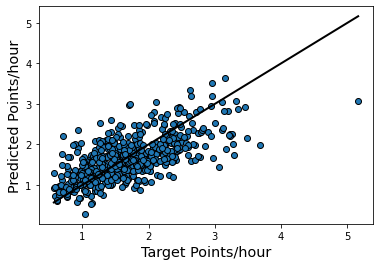

In [33]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=2)
ax.set_xlabel('Target Points/hour', size='x-large')
ax.set_ylabel('Predicted Points/hour', size='x-large')